# EDA
In this notebook, I will take a look at the data and note what are adjustments and engineering might be neccessry to the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

pd.set_option('precision', 4)
pd.options.display.max_seq_items = None


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_pickle('PKL/clean_df.pkl')

In [3]:
df.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.9381,-9.8563,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.6988,-2.1475,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## Data Types
### ID
ID is not a relevant predictor, I will remove this column.

In [4]:
# I'll add them to colstodrop list and drop all at once later
colstodrop = ['id']

### Dates
Since time since is probably important, I'll make these as a continuous integer.  
I will also create a year_recorded column to later engineer the age of the waterpoint.

In [5]:
# separate dates
df['year_recorded'] = [int(x[0:4]) for x in df.date_recorded]
df['date_recorded'] = [int(x.replace('-', '')) for x in df.date_recorded]

### Region code & District code
Even though they are integers, they should be objects. I'll change their filetypes.

In [6]:
# convert region_code and district_code to be objects.
df['region_code'] = df.region_code.astype('object')
df['district_code'] = df.district_code.astype('object')

## Target Variables
Let's see how our target variable is distributed.

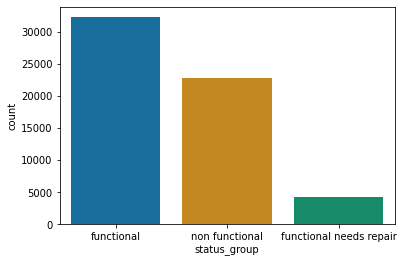

In [7]:
sns.countplot(df.status_group, palette = 'colorblind')
plt.show()

In [8]:
df.status_group.value_counts(normalize = True)

functional                 0.5431
non functional             0.3842
functional needs repair    0.0727
Name: status_group, dtype: float64

Our target variable has some class imbalance issue. 
More than half of our training data are fully functional, while less than 10% are functional but requires repair.

# Continuous variables
I'll take a look at the continuous variables first.

## Total Static Head

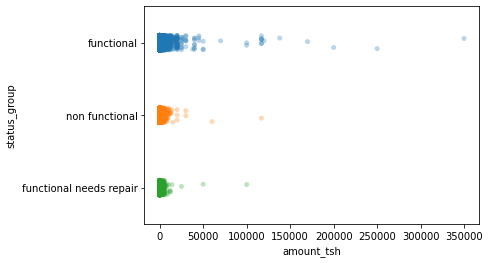

In [9]:
sns.stripplot(x = 'amount_tsh', y = 'status_group', data = df, 
             alpha = 0.3)
plt.show()

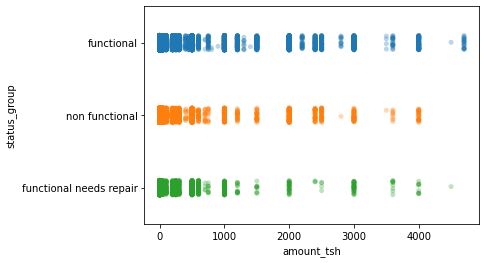

In [10]:
sns.stripplot(x = 'amount_tsh', y = 'status_group', data = df[df.amount_tsh < 5000], 
             alpha = 0.3)
plt.show()

Most values are very small with a few high extreme values. These high value would impact our model. But since the unit information is not present, I cannot figure out if these outliers are error or not. For preprocessing, I should normalize the amount_tsh, and consider removing outliers or capping the max value.

## Altitude of the well (gps_height)


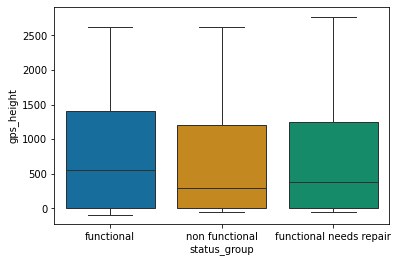

In [11]:
sns.boxplot(x = 'status_group', y = 'gps_height', 
            data = df, linewidth = 1, palette = 'colorblind')
plt.show()

There are some negative altitude, which probably means that the well goes below the sea level. This could have an implication. I should consider adding a binary feature to show this. Also many are 0, this is also possibly missing values, but later I should check how it affects the model by adding a binary column as well.

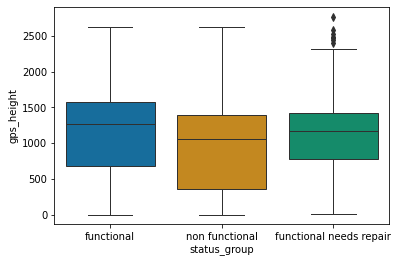

In [12]:
# without negative or zero values
sns.boxplot(x = 'status_group', y = 'gps_height', 
            data = df[df.gps_height > 0], linewidth = 1, palette = 'colorblind')
plt.show()

Functional seems to have a slightly higher gps height.

In [13]:
import scipy.stats as st
st.ttest_ind(df[(df.gps_height > 0) & (df.status_group == 'functional')].gps_height, 
             df[(df.gps_height > 0) & (df.status_group == 'non functional')].gps_height)

Ttest_indResult(statistic=30.600722658837718, pvalue=5.754674377100651e-203)

significant difference between functional and non functional group

## Longitude & Latitude

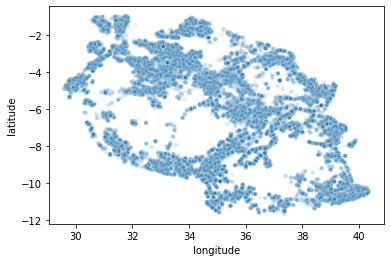

In [14]:
sns.scatterplot(x="longitude", y="latitude", size = 1, alpha = 0.1, data=df, legend=False)

plt.show()

This looks like Tanzania. I'll add their interaction later as a feature.

## Num_private
there's no information on what this value is. Most values have 0 with a handful outliers. I'll see more in detail how this influences our model during feature engineering.

In [15]:
#df.num_private.value_counts()

### Construction year
(since we have many 0 values, I will only look at ones not 0)

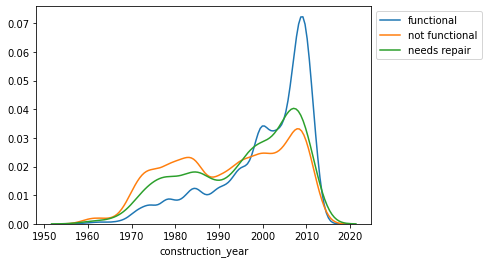

In [16]:
tmp = df[df.construction_year!=0]
sns.distplot(tmp[tmp.status_group == 'functional'].construction_year, hist = False, 
            label='functional')
sns.distplot(tmp[tmp.status_group == 'non functional'].construction_year, hist = False, 
            label = 'not functional')
sns.distplot(tmp[tmp.status_group == 'functional needs repair'].construction_year, hist = False, 
            label = 'needs repair')

plt.legend(bbox_to_anchor = [1, 1])
plt.show()
                 

most functional wells are built recently.

## Categorical values
Now I will look at other categorical values.

In [17]:
#pd.options.display.max_columns = 50

In [18]:
len(set(df.installer)) == len(set([x.lower() for x in df.installer]))

False

It seems like I need to turn all texts into lower case in order to account for any text mishaps.

In [19]:
text_feats = ['funder', 'installer', 'wpt_name', 'basin', 
 'subvillage', 'region', 'lga', 'ward', 'recorded_by', 
 'scheme_management', 'scheme_name', 'extraction_type',
 'extraction_type_group', 'extraction_type_class', 'management',
 'management_group', 'payment', 'payment_type', 'water_quality',
 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
 'source_class', 'waterpoint_type', 'waterpoint_type_group']

for c in text_feats:
    df[c] = [x.lower() for x in df[c]]

Additionally quantity and quantity_group seems to be the same thing so I will remove quantity_group.

In [20]:
# df[df.quantity != df.quantity_group]
colstodrop = colstodrop + ['quantity_group']

### Waterpoint type vs. Waterpoint type group

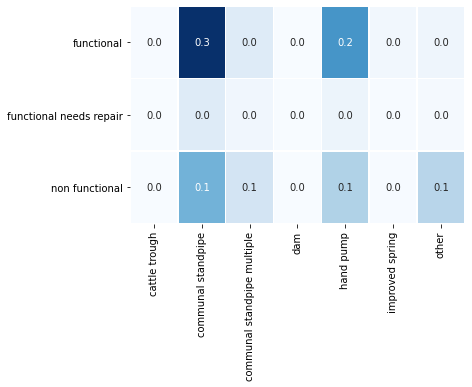

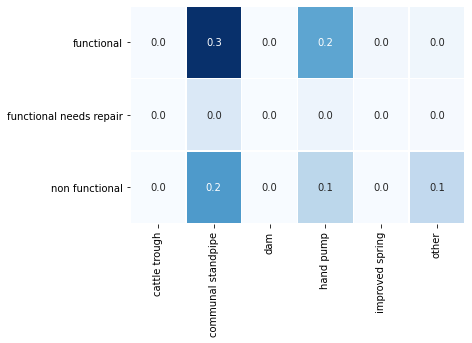

In [50]:
# waterpoint_type
ct = pd.crosstab(df['status_group'], df['waterpoint_type'],normalize = True)
sns.heatmap(ct, annot=True,  fmt = '.1f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

# waterpoint_type_group
ct = pd.crosstab(df['status_group'], df['waterpoint_type_group'],normalize = True)
sns.heatmap(ct, annot=True,  fmt = '.1f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()


It seems like overall trend is the same, except for the waterpoint type divided the communal standpipe to two categories. I should probably just use waterpoint type and not waterpoint type group. Since subgroup changes the pattern slightly.

In [36]:
colstodrop = colstodrop + ['waterpoint_type_group']

### Extraction type, group, class
There are extraction type and group and class. Let's see how they differ.

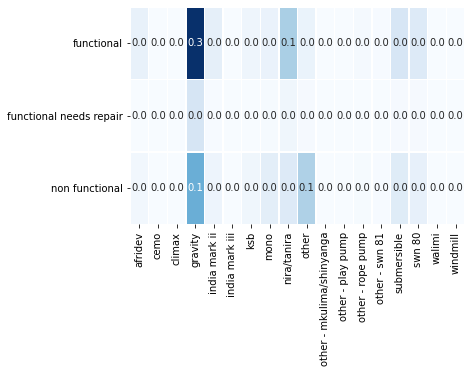

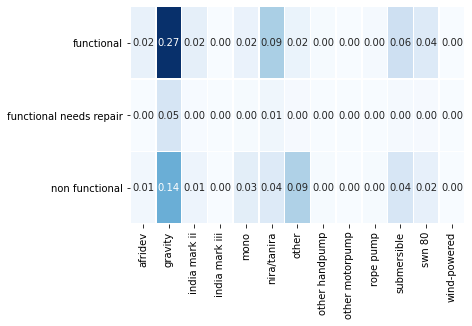

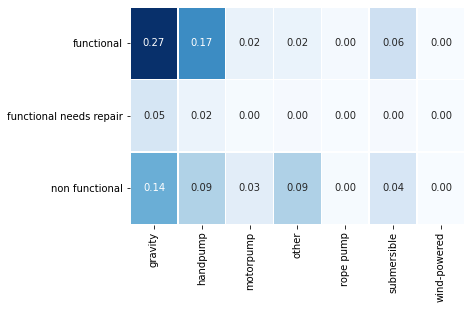

In [49]:
# extraction_type
ct = pd.crosstab(df['status_group'], df['extraction_type'],normalize = True)
sns.heatmap(ct, annot=True,  fmt = '.1f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

# extraction_type_group
ct = pd.crosstab(df['status_group'], df['extraction_type_group'],normalize = True)
sns.heatmap(ct, annot=True, fmt = '.2f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

# extraction_type_class
ct = pd.crosstab(df['status_group'], df['extraction_type_class'],normalize = True)
sns.heatmap(ct, annot=True, fmt = '.2f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()



Again it seems like a same information but different scale of grouping. Types have some classes with 0 values so might not be entirely helpful. It's hard to determine which one should we keep. I'll let the feature selection algorithm to decide.

## Management group vs Management

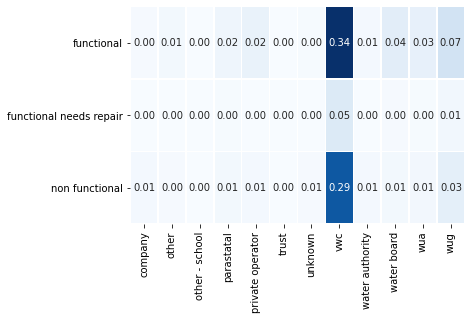

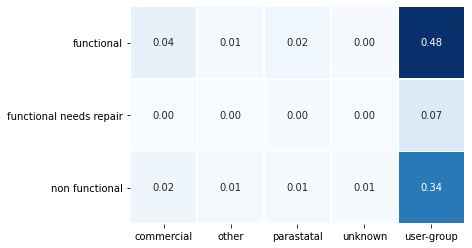

In [47]:
# management
ct = pd.crosstab(df['status_group'], df['management'],normalize = True)
sns.heatmap(ct, annot=True,  fmt = '.2f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

# management_group
ct = pd.crosstab(df['status_group'], df['management_group'],normalize = True)
sns.heatmap(ct, annot=True, fmt = '.2f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()
